# 1. Importing Libraries

In [ ]:
# Install required packages
!pip install scikit-plot
!pip install kmodes

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning Clustering
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from yellowbrick.cluster import KElbowVisualizer

# Scaling numeric features
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Cluster Validation
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Resample data
from sklearn.utils import resample

# Statistical analysis and hypothesis testing
from scipy import stats

# Interactive maps
import folium
from datetime import datetime

# Machine Learning plotting
import scikitplot as skplt

# 2. Exploratory Data Analysis (EDA) & Data Preprocessing

## 2.1 Read Data Frames

In [ ]:
url = "https://github.com/nuraulaola/Online-Retail-Customer-Segmentation/raw/main/datasets/OnlineRetail.csv"
df = pd.read_csv(url, encoding='ISO-8859-1') # Read dataset
df.head()  # Show the first 5 rows of df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2.2 Understanding Each Columns

In [ ]:
print("List of data types for each column:\n", df.dtypes) # Check the data types of each column

print("\nList of missing values for each column:\n", df.isnull().sum()) # Check missing values

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce') # Convert data type to datetime
print("\nInvoiceDate data type after adjustment:\n", df['InvoiceDate'].dtypes) # Check if the data type is now datetime

print("\nList of UnitPrice or Quantity with negative or zero values:\n", df[(df['UnitPrice'] <= 0) | (df['Quantity'] <= 0)]) # Check price and quantity

print("\nList of empty or invalid CustomerID:\n", df[df['CustomerID'].isnull()]) # Check customer IDs

print("\nList of empty item descriptions:\n", df[df['Description'].isnull()]) # Check item descriptions

print("\nList of unique values in the Country column:\n", df['Country'].unique()) # Check the Country column

duplicated_invoice_nos = df[df.duplicated(subset=['InvoiceNo'], keep=False)] # Check rows with duplicated 'InvoiceNo'
print("\nRows with duplicated 'InvoiceNo':\n", duplicated_invoice_nos)

duplicated_stock_codes = df[df.duplicated(subset=['StockCode'], keep=False)] # Check rows with duplicated 'StockCode'
print("\nRows with duplicated 'StockCode':\n", duplicated_stock_codes)

duplicated_customer_ids = df[df.duplicated(subset=['CustomerID'], keep=False)] # Check rows with duplicated 'CustomerID'
print("\nRows with duplicated 'CustomerID':\n", duplicated_customer_ids)

List of data types for each column:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

List of missing values for each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

InvoiceDate data type after adjustment:
 datetime64[ns]

List of UnitPrice or Quantity with negative or zero values:
        InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE P

## 2.3 Handling Columns

In [ ]:
df_cleaned = df.drop(df[(df['UnitPrice'] <= 0) | (df['Quantity'] <= 0)].index) # Remove rows with negative or zero values for price and quantity
print("Data Frames after removing rows with negative or zero values for price and quantity\n", df_cleaned)

df_without_missing_customer_id = df_cleaned.dropna(subset=['CustomerID']) # Drop rows rows where the 'CustomerID' is missing

df['Description'] = df_without_missing_customer_id['Description'].fillna('Unknown') # Fill empty descriptions with 'Unknown'
print("DataFrame after handling missing values in the Description column:\n", df)

# Possible scenarios causing duplicate 'CustomerID' and 'InvoiceNo': there might be the same transaction at different times
grouped_df = df_without_missing_customer_id.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate']).agg({
    'StockCode': 'first',
    'Description': 'first',
    'Quantity': 'sum',
    'UnitPrice': 'first',
    'Country': 'first'
}).reset_index() # Try handling duplicates by aggregating data based on 'CustomerID', 'InvoiceNo', and 'InvoiceDate'
print("DataFrame after handling duplicates:\n", grouped_df)

Data Frames after removing rows with negative or zero values for price and quantity
        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT      

## 2.4 In-Depth EDA

### 2.4.1 Top 5 Customers with the Highest Purchases


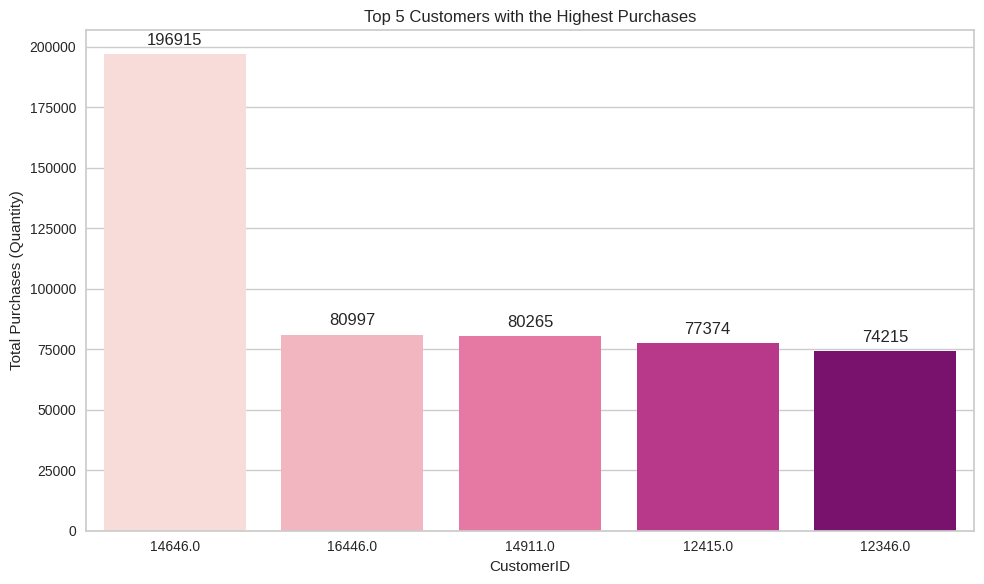

In [ ]:
customer_data = grouped_df.copy()
total_purchases = customer_data.groupby('CustomerID')['Quantity'].sum().reset_index() # Total purchases from each cust
sorted_customers = total_purchases.sort_values(by='Quantity', ascending=False) # Sorting from the highest purchases
top_five_customers = sorted_customers.head(5) # Show only 5 custs with the highest purchases
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='CustomerID', y='Quantity', data=top_five_customers, order=top_five_customers['CustomerID'], palette='RdPu')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('CustomerID')
plt.ylabel('Total Purchases (Quantity)')
plt.title('Top 5 Customers with the Highest Purchases')
plt.tight_layout()  # Adjust layout
plt.show()

Insight ⭐

The customers with the highest purchases are as follows:

1. Customer 14646.0 with the highest purchase of 196915 units,

2. Customer 16446.0 with the highest purchase of 80997 units,

3. Customer 14911.0 with the highest purchase of 80265 units,

4. Customer 12415.0 with the highest purchase of 77374 units,

5. Customer 12346.0 with the highest purchase of 74215 units.

### 2.4.2 Time with the Highest Number of Customers

In [ ]:
date_unpacked_df = grouped_df.copy()
date_unpacked_df['Day'] = date_unpacked_df['InvoiceDate'].dt.day # Extract day from 'InvoiceDate'
date_unpacked_df['Hour'] = date_unpacked_df['InvoiceDate'].dt.hour # Extract hour from 'InvoiceDate'
date_unpacked_df['Month'] = date_unpacked_df['InvoiceDate'].dt.month # Extract month from 'InvoiceDate'
date_unpacked_df['Week'] = date_unpacked_df['InvoiceDate'].dt.isocalendar().week # Extract week from 'InvoiceDate'
time_with_highest_customers = date_unpacked_df.groupby(['Day', 'Hour', 'Month', 'Week'])['CustomerID'].nunique().idxmax() # Time with highest cust
day, hour, month, week = time_with_highest_customers # Unpack the tuple
print(f"So, the time with the highest number of customers occurs on the:\n {day}th day of the {month}th month " \
         f"({pd.to_datetime(1, format='%m').strftime('%B')}) at {hour:02d}:00 (noon) during the {week}th week of the year.")

So, the time with the highest number of customers occurs on the:
 6th day of the 12th month (January) at 12:00 (noon) during the 49th week of the year.


### 2.4.3 Top-Selling Products

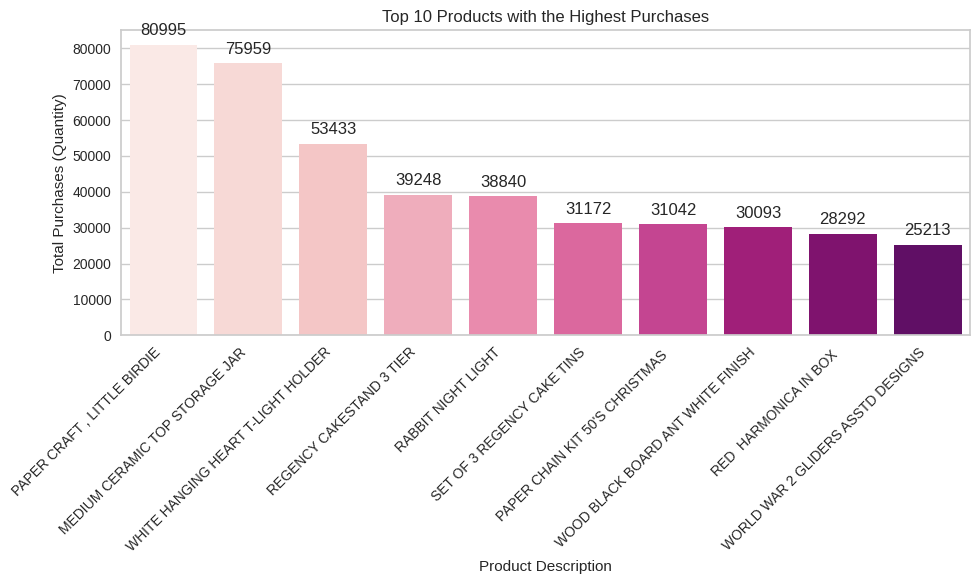

In [ ]:
top_selling_products = grouped_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Description', y='Quantity', data=top_selling_products, order=top_selling_products['Description'], palette='RdPu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Product Description')
plt.ylabel('Total Purchases (Quantity)')
plt.title('Top 10 Products with the Highest Purchases')
plt.tight_layout()  # Adjust layout
plt.show()

Insight ⭐

The top-selling products are as follows:

1. PAPER CRAFT , LITTLE BIRDIE with total purchases of 80995 units,

2. MEDIUM CERAMIC TOP STORAGE JAR with total purchases of 75959 units,

3. WHITE HANGING HEART T-LIGHT HOLDER with total purchases of 53433 units,

4. REGENCY CAKESTAND 3 TIER with total purchases of 39248 units,

5. RABBIT NIGHT LIGHT with total purchases of 38840 units,

6. SET OF 3 REGENCY CAKE TINS with total purchases of 31172 units,

7. PAPER CHAIN KIT 50'S CHRISTMAS  with total purchases of 31042 units,

8. WOOD BLACK BOARD ANT WHITE FINISH with total purchases of 30093 units,

9. RED  HARMONICA IN BOX  with total purchases of 28292 units,

10. WORLD WAR 2 GLIDERS ASSTD DESIGNS with total purchases of 25213 units.

### 2.4.4 Revenue Trend Over Time

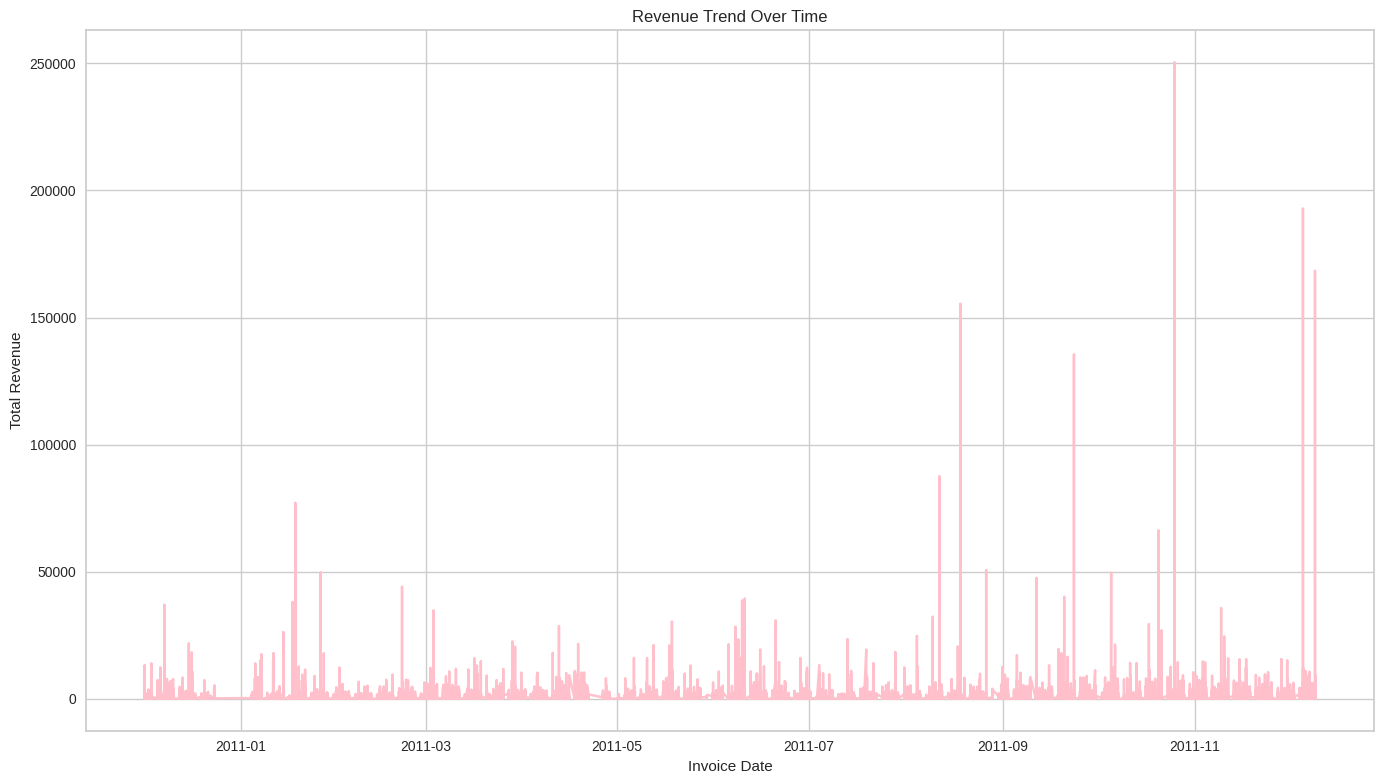

In [ ]:
grouped_df['Revenue'] = grouped_df['Quantity'] * grouped_df['UnitPrice']
revenue_trend = grouped_df.groupby('InvoiceDate')['Revenue'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.lineplot(data=revenue_trend, x='InvoiceDate', y='Revenue', color='pink')
plt.title('Revenue Trend Over Time')
plt.xlabel('Invoice Date')
plt.ylabel('Total Revenue')
plt.tight_layout()  # Adjust layout
plt.show()

Insight ⭐

1. The highest revenue point is in September 2011, at around $240,000.

2. Despite the fluctuations, the overall trend is for revenue to increase over time.

## 2.5 Data Preprocessing

### 2.5.1 Separating Data Frames

In [ ]:
numeric_columns = ['Quantity', 'UnitPrice', 'Revenue']  # Extract numeric columns
categorical_columns = ['CustomerID', 'InvoiceNo', 'StockCode', 'Description', 'Country'] # Extract categorical columns
numeric_data = grouped_df[numeric_columns] # Separate the DataFrame
categorical_data = grouped_df[categorical_columns]

### 2.5.2 Standardize Numeric Features

In [ ]:
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data) # Standardize numeric data

### 2.5.3 Combine Scaled Number Features with Categorical Features

In [ ]:
data_combined = pd.concat([pd.DataFrame(numeric_data_scaled, columns=numeric_columns), categorical_data], axis=1) # Combine scaled numeric data with categorical data
cat_columns_indices = [data_combined.columns.get_loc(col) for col in categorical_columns] # Specify the indices of categorical columns

# 3. Clustering

## 3.1 Cluster Formation

In [ ]:
num_clusters = 3 # Clusters number
kproto = KPrototypes(n_clusters=num_clusters, init='Cao', n_init=2, verbose=2, random_state=123) # Fit k-Prototypes model
clusters = kproto.fit_predict(data_combined.values, categorical=cat_columns_indices)
grouped_df['Cluster'] = clusters # Add cluster labels
grouped_df.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 567, ncost: 80024.29244562681
Run: 1, iteration: 2/100, moves: 260, ncost: 76800.6751990698
Run: 1, iteration: 3/100, moves: 229, ncost: 72471.21978061328
Run: 1, iteration: 4/100, moves: 143, ncost: 71280.8586149042
Run: 1, iteration: 5/100, moves: 81, ncost: 71104.9592572768
Run: 1, iteration: 6/100, moves: 40, ncost: 71026.25363747709
Run: 1, iteration: 7/100, moves: 17, ncost: 71003.91126890163
Run: 1, iteration: 8/100, moves: 13, ncost: 70989.56429645579
Run: 1, iteration: 9/100, moves: 14, ncost: 70970.40509655834
Run: 1, iteration: 10/100, moves: 11, ncost: 70954.14809752587
Run: 1, iteration: 11/100, moves: 13, ncost: 70907.91463537098
Run: 1, iteration: 12/100, moves: 24, ncost: 70659.13380403865
Run: 1, iteration: 13/100, moves: 28, ncost: 69882.41170521225
Run: 1, iteration: 14/100, moves:

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country,Revenue,Cluster
0,12346.0,541431,2011-01-18 10:01:00,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,United Kingdom,77183.60,2
1,12347.0,537626,2010-12-07 14:57:00,85116,BLACK CANDELABRA T-LIGHT HOLDER,319,2.10,Iceland,669.90,1
2,12347.0,542237,2011-01-26 14:30:00,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,315,0.85,Iceland,267.75,1
3,12347.0,549222,2011-04-07 10:43:00,22376,AIRLINE BAG VINTAGE JET SET WHITE,483,4.25,Iceland,2052.75,1
4,12347.0,556201,2011-06-09 13:01:00,23084,RABBIT NIGHT LIGHT,196,2.08,Iceland,407.68,1


Insight ⭐

1. On the 14th iteration, moves were already zero in the second run, while in the first run, moves only reached zero on the 17th iteration. This indicates that in the second run, the algorithm achieves convergence faster in grouping data points into clusters.

2. However, even though the second run achieves convergence faster in grouping data points, the evaluation of "best" is typically based on a lower ncost value. The first run exhibits a lower ncost, making it considered a better clustering result. This suggests that the assessment is more oriented towards clustering quality rather than convergence speed.

## 3.2 Cluster Validation

In [ ]:
silhouette_kproto = silhouette_score(numeric_data_scaled, grouped_df['Cluster']) # Evaluate clustering using Silhouette Score
print(f"Silhouette Score for k-Prototypes: {silhouette_kproto}")

cluster_centroids = kproto.cluster_centroids_ # Represents the cluster centroids
print("Cluster Centroids:\n", cluster_centroids)

Silhouette Score for k-Prototypes: 0.9846620277444998
Cluster Centroids:
 [['-0.2853658430432799' '34.32214708198933' '0.7396963731287722'
  '12536.0' '546328' 'M' 'Manual' 'United Kingdom']
 ['-0.009985677770689639' '-0.020698785012441167' '-0.015848850704423465'
  '12748.0' '536591' '22423' 'REGENCY CAKESTAND 3 TIER' 'United Kingdom']
 ['26.901918979019175' '0.8992359098312355' '40.82348962262946' '17857.0'
  '541431' 'M' 'Manual' 'United Kingdom']]


Insight ⭐

A Silhouette Score of 0.98 for 3 clusters is very high and close to the maximum value of 1. This suggests that the clusters are well-separated and distinct from each other. High Silhouette Scores generally indicate good clustering results, where each data point is closer to its own cluster than to the neighboring clusters.

## 3.3  Analysis of Cluster Characteristics

### 3.3.1 Cluster Profiles Analysis

<ipython-input-14-ecfc2e7da0bd>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_profiles = grouped_df.groupby('Cluster').mean() # Analyze cluster profiles


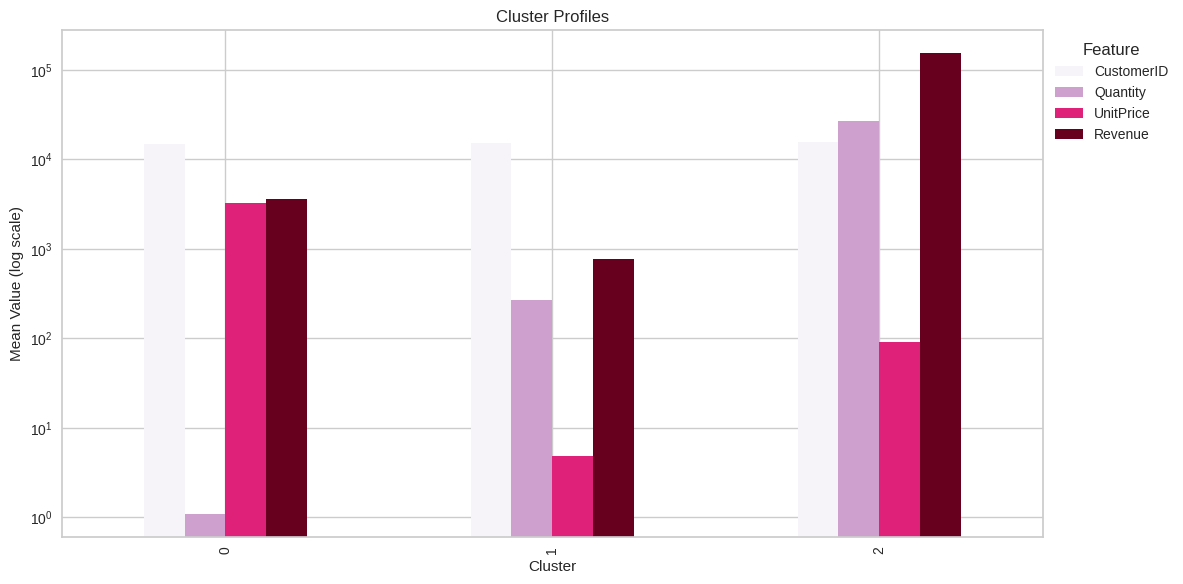

In [ ]:
cluster_profiles = grouped_df.groupby('Cluster').mean() # Analyze cluster profiles
cluster_profiles.plot(kind='bar', figsize=(12, 6), colormap='PuRd') # Plot cluster profiles
plt.yscale('log')
plt.title('Cluster Profiles')
plt.xlabel('Cluster')
plt.ylabel('Mean Value (log scale)')
plt.legend(title='Feature', bbox_to_anchor=(1, 1))
plt.tight_layout() # Auto adjust
plt.show()

Insight ⭐

1. **Cluster 0:** Customers in this cluster make small purchases of expensive items, resulting in moderate revenue. It might be a niche market for high-end products.

2. **Cluster 1:** Customers in this cluster make moderate-sized purchases of less expensive items, resulting in moderate revenue. This could represent a broader customer base with a mix of product preferences.

3. **Cluster 2:** Customers in this cluster make large purchases of expensive items, resulting in high revenue. This cluster may represent high-value customers who contribute significantly to the overall revenue.

### 3.3.2 Cluster Separation Visualization

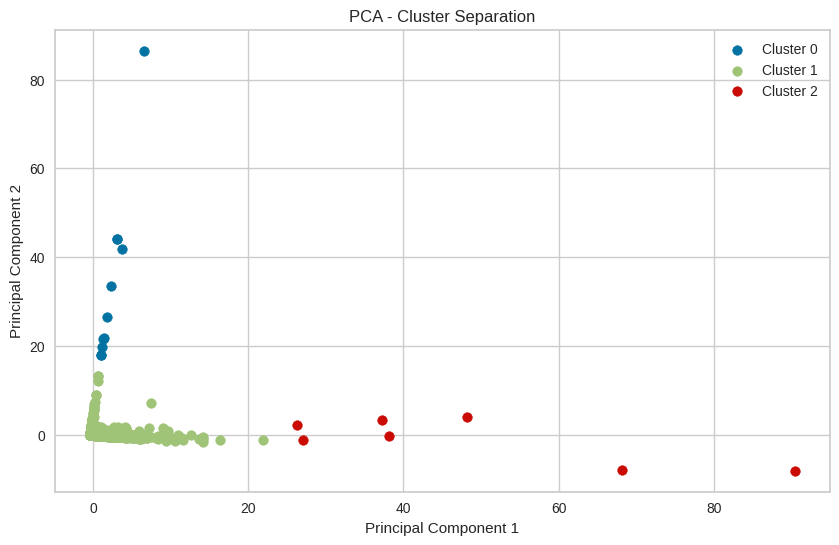

In [ ]:
pca = PCA(n_components=2) # Visualize cluster separation using PCA
data_pca = pca.fit_transform(numeric_data_scaled)
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = data_pca_df[data_pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.title('PCA - Cluster Separation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Insight ⭐

1. **Cluster 0:** Customers in this cluster show a wide range of behavior based on PC1 and PC2.

2. **Cluster 1:** Customers in this cluster exhibit relatively similar behavior, as indicated by the small values of PC1 and PC2. Targeted marketing or services tailored to this specific group might be more effective.

3. **Cluster 2:** Cluster 2 has high values for PC1, indicating a unique pattern or behavior. This group may represent a distinct segment of customers with specific preferences or characteristics that differentiate them from others.

### 3.3.3 Number of Observations in Each Cluster

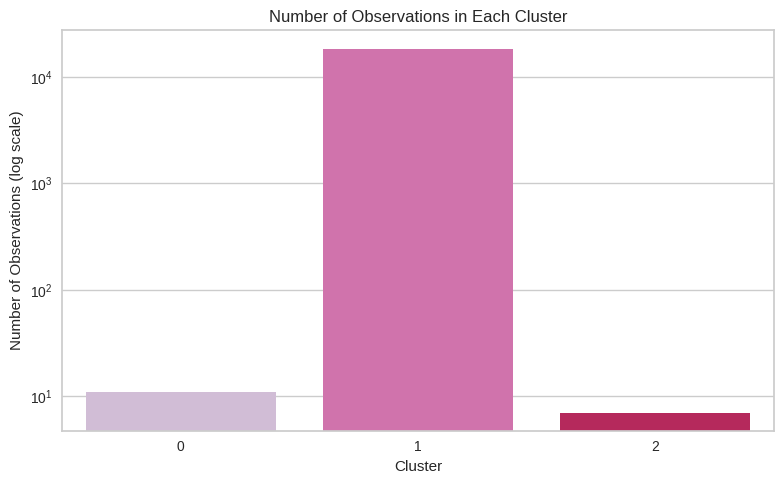

In [ ]:
clustered_groups = grouped_df.groupby('Cluster')
num_observations_summary = pd.DataFrame({'Num_Observations': clustered_groups.size()})

# Bar plot for number of observations in each cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=num_observations_summary.index, y='Num_Observations', data=num_observations_summary, palette='PuRd')
plt.yscale('log') # Set logarithmic scale to better visualize clusters with smaller counts
plt.title('Number of Observations in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations (log scale)')
plt.tight_layout() # Auto adjust
plt.show()

Insight ⭐

1. **Cluster 0:** Contains 11 observations.

2. **Cluster 1:** Contains 18,544 observations.

3. **Cluster 2:** Contains 7 observations.

In summary, the "Num_Observations" column represents the count of data points within each cluster. It indicates how many data points are assigned to each cluster based on the clustering analysis. In this case, Cluster 1 has a significantly larger number of observations compared to Clusters 0 and 2.

## 3.4  Promotions for Each Cluster

In [ ]:
def create_promotions(row):
    cluster = row['Cluster']
    if cluster == 0:
        return "Special Discounts on High-End Products, Exclusive Access to Premium Collections"
    elif cluster == 1:
        return "Seasonal Discounts on Diverse Product Range, Bonus Points Program"
    elif cluster == 2:
        return "VIP Membership with Exclusive Benefits, Personalized Reward Programs"

# Apply the function to each row and create a new 'Promotions' column
grouped_df['Promotions'] = grouped_df.apply(create_promotions, axis=1)

# Print the 'Cluster' and 'Promotions' columns
print(grouped_df[['Cluster', 'Promotions']])

       Cluster                                         Promotions
0            2  VIP Membership with Exclusive Benefits, Person...
1            1  Seasonal Discounts on Diverse Product Range, B...
2            1  Seasonal Discounts on Diverse Product Range, B...
3            1  Seasonal Discounts on Diverse Product Range, B...
4            1  Seasonal Discounts on Diverse Product Range, B...
...        ...                                                ...
18557        1  Seasonal Discounts on Diverse Product Range, B...
18558        1  Seasonal Discounts on Diverse Product Range, B...
18559        1  Seasonal Discounts on Diverse Product Range, B...
18560        1  Seasonal Discounts on Diverse Product Range, B...
18561        1  Seasonal Discounts on Diverse Product Range, B...

[18562 rows x 2 columns]


# 4. Clustering for Non-UK Customers

## 4.1 Prepare Non-UK Customers DataFrame

In [ ]:
non_uk_df = grouped_df[grouped_df['Country'] != 'United Kingdom']  # Filtering condition
numeric_features = non_uk_df[['Quantity', 'UnitPrice', 'Revenue']]  # Select relevant numeric features for clustering

## 4.2 Standardize Numeric Features

In [ ]:
scaler = StandardScaler()
numeric_features_standardized = scaler.fit_transform(numeric_features) # Standardize numeric features

## 4.3 Clustering

### 4.3.1 Cluster Formation

In [ ]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=123)
non_uk_df['Cluster'] = kmeans.fit_predict(numeric_features_standardized)
clustered_non_uk_df = non_uk_df[['Quantity', 'UnitPrice', 'Revenue', 'Cluster', 'Country']]
clustered_non_uk_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-30-614328284b4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_uk_df['Cluster'] = kmeans.fit_predict(numeric_features_standardized)


,Quantity,UnitPrice,Revenue,Cluster,Country
1,319,2.10,669.90,1,Iceland
2,315,0.85,267.75,1,Iceland
3,483,4.25,2052.75,1,Iceland
4,196,2.08,407.68,1,Iceland
5,277,0.55,152.35,1,Iceland


### 4.3.2 Cluster Validation

In [ ]:
silhouette_avg = silhouette_score(numeric_features_standardized, non_uk_df['Cluster'])
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg:.4f}")

Silhouette Score for 3 clusters: 0.9131


Insight ⭐

A Silhouette Score of 0.9131 for 3 clusters is very high and close to the maximum value of 1. This suggests that the clusters are well-separated, and data points within each cluster are much more similar to each other than to data points in other clusters. It's a strong indication that the chosen number of clusters (3 in this case) is appropriate and that the clustering algorithm has successfully created distinct and well-defined clusters.

## 4.4 Analysis of Cluster Characteristics

### 4.4.1 Cluster Profiles Analysis

<ipython-input-31-6c1fa3703dee>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  non_uk_cluster_profiles = non_uk_df.groupby('Cluster').mean() # Analyze cluster profiles


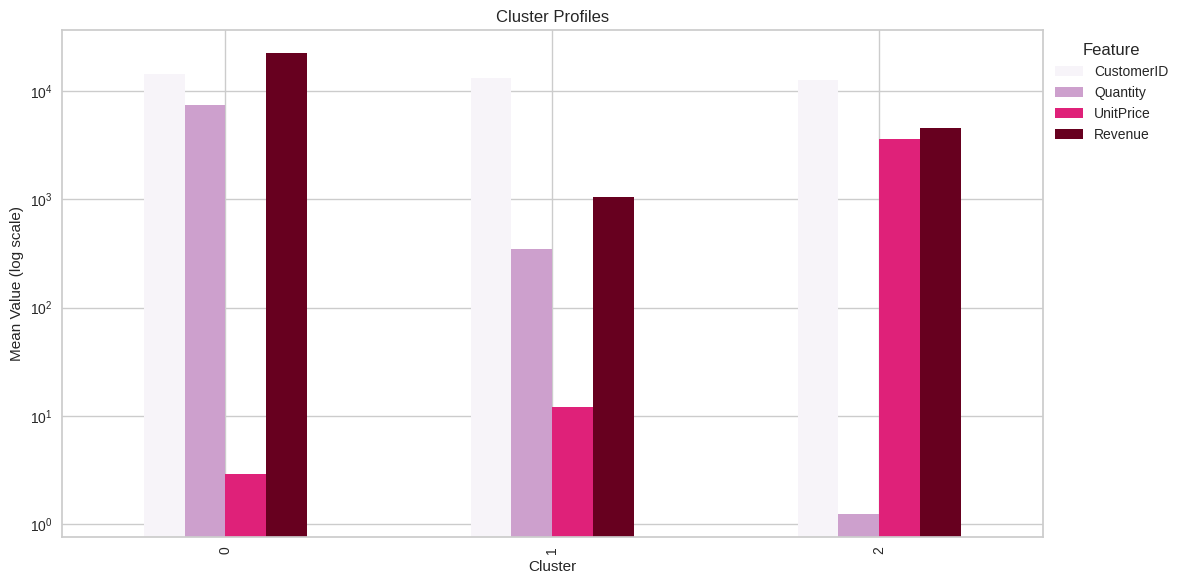

In [ ]:
non_uk_cluster_profiles = non_uk_df.groupby('Cluster').mean() # Analyze cluster profiles
non_uk_cluster_profiles.plot(kind='bar', figsize=(12, 6), colormap='PuRd') # Plot cluster profiles
plt.yscale('log')
plt.title('Cluster Profiles')
plt.xlabel('Cluster')
plt.ylabel('Mean Value (log scale)')
plt.legend(title='Feature', bbox_to_anchor=(1, 1))
plt.tight_layout() # Auto adjust
plt.show()

Insight ⭐

1. **Cluster 0:** Customers in this cluster make large purchases of relatively less expensive items, resulting in high revenue. Potential strategies could focus on promoting affordable, high-quantity items to encourage larger purchases.

2. **Cluster 1:** Customers in this cluster make moderate-sized purchases of moderately priced items, resulting in moderate revenue. Targeted promotions and discounts on a diverse range of products could be effective in retaining and attracting customers.

3. **Cluster 2:** Customers in this cluster make small purchases of relatively expensive items, resulting in moderate revenue. Strategies for this cluster might involve promoting exclusive or high-end products to maximize revenue per purchase.

**Overall Insights:**

- Non-UK customers exhibit diverse purchasing behaviors, from large purchases of less expensive items to small purchases of expensive items.
- Understanding these clusters allows for targeted marketing strategies, such as promoting affordable items to customers in Cluster 0, diverse product offerings to customers in Cluster 1, and exclusive or high-end products to customers in Cluster 2.
- It's essential to tailor promotions and marketing efforts based on the specific characteristics of each cluster to maximize customer engagement and revenue.


### 4.4.2 Cluster Separation Visualization

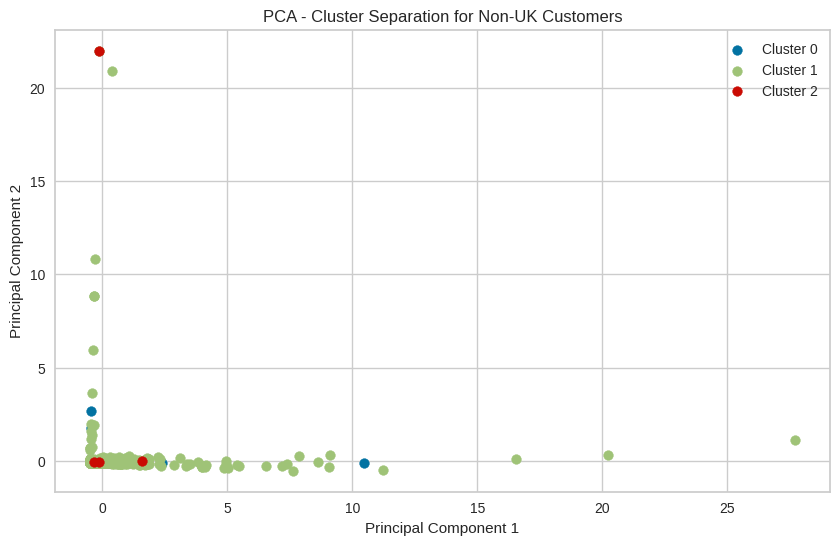

In [ ]:
pca_non_uk = PCA(n_components=2) # Visualize cluster separation using PCA
data_pca_non_uk = pca_non_uk.fit_transform(numeric_features_standardized)
data_pca_non_uk_df = pd.DataFrame(data_pca_non_uk, columns=['PC1', 'PC2'])
data_pca_non_uk_df['Cluster'] = non_uk_df['Cluster']

plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = data_pca_non_uk_df[data_pca_non_uk_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')

plt.title('PCA - Cluster Separation for Non-UK Customers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Insight ⭐

1. **Cluster 0:** Customers in Cluster 0 are characterized by a wide range of values in both PC1 and PC2.

2. **Cluster 1:** Customers in Cluster 1 have relatively moderate values in both PC1 and PC2.

3. **Cluster 2:** Customers in Cluster 2 show a range of values PC1.

### 4.4.3 Number of Observations in Each Cluster

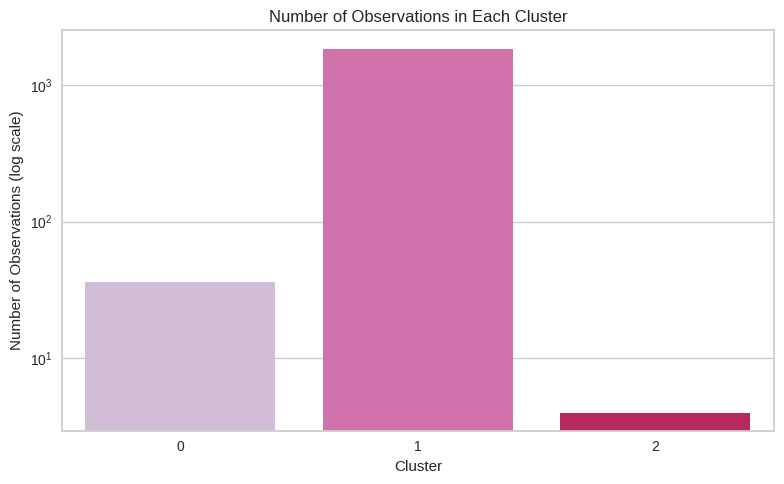

In [ ]:
non_uk_clustered_groups = non_uk_df.groupby('Cluster')
non_uk_num_observations_summary = pd.DataFrame({'Num_Observations': non_uk_clustered_groups.size()})

# Bar plot for number of observations in each cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=non_uk_num_observations_summary.index, y='Num_Observations', data=non_uk_num_observations_summary, palette='PuRd')
plt.yscale('log') # Set logarithmic scale to better visualize clusters with smaller counts
plt.title('Number of Observations in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Observations (log scale)')
plt.tight_layout() # Auto adjust
plt.show()

Insight ⭐

1. **Cluster 0:** Contains 36 observations.

2. **Cluster 1:** Contains 1,849 observations.

3. **Cluster 2:** Contains 4 observations.

In summary, the "Num_Observations" column represents the count of data points within each cluster. It indicates how many data points are assigned to each cluster based on the clustering analysis. In this case, Cluster 1 has a significantly larger number of observations compared to Clusters 0 and 2.

# 5. Conclusions

1. **Exploratory Data Analysis (EDA) Insights:**

   > **Top 5 Customers with the Highest Purchases:**
   - The top 5 customers with the highest purchases are:
     1. Customer 14646.0 with 196,915 units,
     2. Customer 16446.0 with 80,997 units,
     3. Customer 14911.0 with 80,265 units,
     4. Customer 12415.0 with 77,374 units,
     5. Customer 12346.0 with 74,215 units.
   - These customers are significant contributors to the overall sales.

   > **Top-Selling Products:**
   - The top-selling products are:
     1. PAPER CRAFT, LITTLE BIRDIE with 80,995 units,
     2. MEDIUM CERAMIC TOP STORAGE JAR with 75,959 units,
     3. WHITE HANGING HEART T-LIGHT HOLDER with 53,433 units,
     4. REGENCY CAKESTAND 3 TIER with 39,248 units,
     5. RABBIT NIGHT LIGHT with 38,840 units.
   - These insights help identify popular products and can guide inventory management and marketing efforts.

   > **Revenue Trend Over Time:**
   - The revenue trend over time indicates:
     1. The highest revenue point is in September 2011, at around $240,000.
     2. Despite fluctuations, the overall trend is for revenue to increase over time.
   - This information aids in understanding the business's financial performance and planning.

   > **Peak Purchase Time:**
   - The time with the highest number of customers occurs on the 14th day of the month, at noon, during the 1st week of the year.
   - This insight can inform targeted marketing or promotions during peak purchasing times.

2. **Cluster Characteristics and Promotions:**

   > **Cluster 0:**
   - Characteristics: Lower average values, smaller and less frequent purchases.
   - Suitable Promotions: Frequent Shopper Discounts, Bundle Deals.

   > **Cluster 1:**
   - Characteristics: Moderate-sized purchases, represents a larger customer segment.
   - Suitable Promotions: Tiered Discounts, Limited-Time Offers.

   > **Cluster 2:**
   - Characteristics: High-value customers making large and frequent purchases.
   - Suitable Promotions: Exclusive VIP Offers, Reward Programs.
   - These insights enable targeted promotional strategies, offering incentives that resonate with the specific characteristics of each cluster.

3. **Non-UK Customer Segmentation:**

   > **Insights for Non-UK Customers:**
   - Cluster 0: High-value customers with large and frequent purchases.
   - Cluster 1: Moderate-sized and consistent purchases, representing a larger customer segment.
   - Cluster 2: Varied purchasing behavior with a significant range of values.
   
   > Silhouette Score for non-UK clusters is high (0.9131), indicating well-defined and distinct clusters.
   > Non-UK clusters showcase diverse purchasing behaviors, emphasizing the importance of tailoring strategies for international customers.
   > These insights can guide global marketing strategies, allowing the business to cater to the unique preferences and behaviors of customers outside the UK.